In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import time

### `generate_dataset`

#### Parameters:
- `n_samples`: Number of data points.
- `n_true_predictors`: Number of effective features.
- `n_non_effective_predictors`: Number of noise features.

#### Steps:

1. **Generate Predictors**:  
   **True Predictors**: `n_true_predictors` arrays of random values.  
   **Non-effective Predictors**: `n_non_effective_predictors` arrays of random values.

2. **Define Coefficients and Intercept**:  
   `beta_0`: Intercept (3.0).  
   `true_coefficients`: Random values (3.5 to 8) for true predictors.

3. **Generate Error Term**:  
   Random noise from a standard normal distribution.

4. **Generate Outcome Variable (`y`)**:  
   Calculated as the sum of the intercept, true predictors multiplied by their coefficients, and the error term.

5. **Combine Predictors into a DataFrame**:  
   Creates a DataFrame with predictors and the outcome variable `y`.

6. **Return**:  
   The DataFrame and true coefficients.

In [2]:
def generate_dataset(n_samples, n_true_predictors, n_non_effective_predictors):
    np.random.seed(8)
    
    # Generate true predictors
    true_predictors = [np.random.rand(n_samples, 1) for _ in range(n_true_predictors)]
    
    # Generate non-effective predictors
    non_effective_predictors = [np.random.rand(n_samples, 1) for _ in range(n_non_effective_predictors)]
    
    # Define the true coefficients and intercept
    beta_0 = 3.0
    true_coefficients = np.random.uniform(2, 10, size=n_true_predictors)
    
    # Generate the error term
    error = np.random.randn(n_samples, 1)
    
    # Generate the outcome variable
    y = beta_0 + sum(beta * x for beta, x in zip(true_coefficients, true_predictors)) + error
    
    # Combine all predictors into a single DataFrame
    predictors = np.hstack(true_predictors + non_effective_predictors)
    columns = [f'x{i+1}' for i in range(n_true_predictors + n_non_effective_predictors)]
    data = pd.DataFrame(predictors, columns=columns)
    data['y'] = y
    
    return data, true_coefficients

In [3]:
# Generate the dataset
n_samples = 30_000
n_true_predictors = 50
n_non_effective_predictors = 250
data, true_coefficients = generate_dataset(n_samples, n_true_predictors, n_non_effective_predictors)

true_coefficients

array([8.38984537, 9.82696424, 7.94697034, 3.61841482, 7.01683696,
       5.73736521, 3.60996976, 3.96827357, 4.79788983, 2.55410511,
       8.90432498, 8.16788981, 7.35608733, 2.53250268, 7.9010034 ,
       5.14763294, 7.46202028, 4.21277596, 5.06036139, 2.30783058,
       3.81719011, 7.75687505, 5.50871043, 8.3602481 , 9.99894283,
       8.22110945, 7.85625741, 9.08571737, 4.1784214 , 6.74659015,
       9.27892757, 5.83013222, 5.76461824, 2.69817821, 5.97280944,
       2.89975382, 8.47048356, 7.15687003, 3.89257488, 9.99818249,
       3.65457813, 7.48503638, 8.06152341, 5.92650828, 5.88873536,
       8.84854431, 9.42644377, 2.92741233, 6.76343701, 5.36231618])

In [4]:
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x292,x293,x294,x295,x296,x297,x298,x299,x300,y
0,0.873429,0.968232,0.849903,0.103293,0.281683,0.737868,0.918060,0.541522,0.207263,0.149429,...,0.041081,0.549143,0.723315,0.436167,0.352149,0.766831,0.444255,0.572136,0.017275,176.798254
1,0.968541,0.676999,0.843904,0.922206,0.698935,0.450418,0.122268,0.515558,0.445657,0.173626,...,0.907549,0.899262,0.501460,0.828572,0.914693,0.750214,0.487761,0.525497,0.691475,159.168367
2,0.869195,0.822084,0.565280,0.599747,0.221246,0.513138,0.045276,0.109566,0.053134,0.559037,...,0.967694,0.707330,0.666353,0.622368,0.088663,0.117395,0.584255,0.839989,0.705306,132.584736
3,0.530856,0.518521,0.559811,0.222248,0.097998,0.917697,0.469445,0.170623,0.744574,0.286281,...,0.276408,0.037200,0.358341,0.661921,0.605160,0.083128,0.667790,0.537201,0.906849,151.478088
4,0.232728,0.127392,0.961259,0.772161,0.065954,0.391809,0.301499,0.850425,0.088409,0.579290,...,0.044193,0.786021,0.084884,0.716330,0.073971,0.555774,0.085050,0.607052,0.664847,159.621846


In [5]:
data.shape

(30000, 301)

In [6]:
X = data.drop(columns='y')
y = data['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

## Basic linear model for baseline coeff in order to compare how Lasso changes the coeff

In [7]:
basic_lr = LinearRegression()

# Fit the model to the training data
basic_lr.fit(X_train, y_train)

lr_pred = basic_lr.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, lr_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1.0106161350259004


In [8]:
initial_coefficients = basic_lr.coef_
initial_coefficients

array([ 8.37783361e+00,  9.80723527e+00,  7.95037055e+00,  3.58217122e+00,
        7.03297895e+00,  5.77844937e+00,  3.62606259e+00,  3.99525586e+00,
        4.80166049e+00,  2.56967419e+00,  8.94595607e+00,  8.18983164e+00,
        7.36675617e+00,  2.51894340e+00,  7.88287961e+00,  5.14065607e+00,
        7.44979563e+00,  4.23071709e+00,  5.03576400e+00,  2.31165460e+00,
        3.82562949e+00,  7.78680491e+00,  5.53538325e+00,  8.35572003e+00,
        1.00132039e+01,  8.18631978e+00,  7.83806908e+00,  9.08608380e+00,
        4.18425676e+00,  6.74705222e+00,  9.29946266e+00,  5.87432065e+00,
        5.76227262e+00,  2.68647040e+00,  6.00017106e+00,  2.89914756e+00,
        8.46234784e+00,  7.18525745e+00,  3.89495778e+00,  1.00152021e+01,
        3.63434434e+00,  7.49131553e+00,  8.06509139e+00,  5.94199133e+00,
        5.87886369e+00,  8.88110562e+00,  9.43908407e+00,  2.92703283e+00,
        6.82717742e+00,  5.33289856e+00,  3.31939518e-02, -1.08055176e-02,
        2.40033482e-03, -

In [9]:
# Define the Lasso model
lasso = LassoCV(cv=5, random_state=8, n_jobs=-1)  

start_time = time.time()
lasso.fit(X_train, y_train)

best_alpha = lasso.alpha_
print("Optimal alpha:", best_alpha)

Optimal alpha: 0.002083721552598941


In [10]:
lasso_final = Lasso(alpha=best_alpha)

# Fit the final model to the training data
lasso_final.fit(X_train, y_train)

# Predict on test data and time
y_pred = lasso_final.predict(X_test)
end_time = time.time()

In [11]:
# Calculate the mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 0.9994504293906008


In [12]:
r2 = r2_score(y_test, y_pred)
print(f"R^2 score: {r2}")

R^2 score: 0.9946313082854399


In [13]:
estimation_time = end_time - start_time
print(estimation_time)

1.0209269523620605


In [14]:
lasso_coefficients = lasso_final.coef_
lasso_coefficients

array([ 8.34831883e+00,  9.78135836e+00,  7.92808905e+00,  3.55637372e+00,
        7.00737013e+00,  5.75372489e+00,  3.59796156e+00,  3.96736956e+00,
        4.78135046e+00,  2.54143902e+00,  8.91940073e+00,  8.16444541e+00,
        7.33759125e+00,  2.49506874e+00,  7.85715340e+00,  5.11553811e+00,
        7.42132714e+00,  4.20546302e+00,  5.00890854e+00,  2.28438044e+00,
        3.80201076e+00,  7.75968610e+00,  5.50957937e+00,  8.32879848e+00,
        9.99133246e+00,  8.16212074e+00,  7.81339198e+00,  9.06393822e+00,
        4.15983038e+00,  6.71896729e+00,  9.27381367e+00,  5.85114993e+00,
        5.73980212e+00,  2.65680388e+00,  5.97097829e+00,  2.87847020e+00,
        8.43783113e+00,  7.16010304e+00,  3.87168823e+00,  9.98984274e+00,
        3.61128141e+00,  7.46676986e+00,  8.03922719e+00,  5.91522742e+00,
        5.85409673e+00,  8.85649569e+00,  9.41367403e+00,  2.90643827e+00,
        6.80054021e+00,  5.30325668e+00,  7.48384554e-03, -0.00000000e+00,
        0.00000000e+00, -

In [15]:
start_time = time.time()

# Create a DataFrame to compare the coefficients
coefficients_df = pd.DataFrame({
    'Feature_Index': np.arange(len(X.columns)),
    'Feature': X.columns,
    'Initial_Coefficients': initial_coefficients,
    'Lasso_Coefficients': lasso_coefficients
})

zero_indices = coefficients_df[coefficients_df['Lasso_Coefficients'] == 0]['Feature_Index']

In [16]:
coefficients_df

,Feature_Index,Feature,Initial_Coefficients,Lasso_Coefficients
0,0,x1,8.377834,8.348319
1,1,x2,9.807235,9.781358
2,2,x3,7.950371,7.928089
3,3,x4,3.582171,3.556374
4,4,x5,7.032979,7.007370
...,...,...,...,...
295,295,x296,-0.030251,-0.005836
296,296,x297,-0.022764,-0.000000
297,297,x298,0.021517,0.000000
298,298,x299,-0.033273,-0.008494


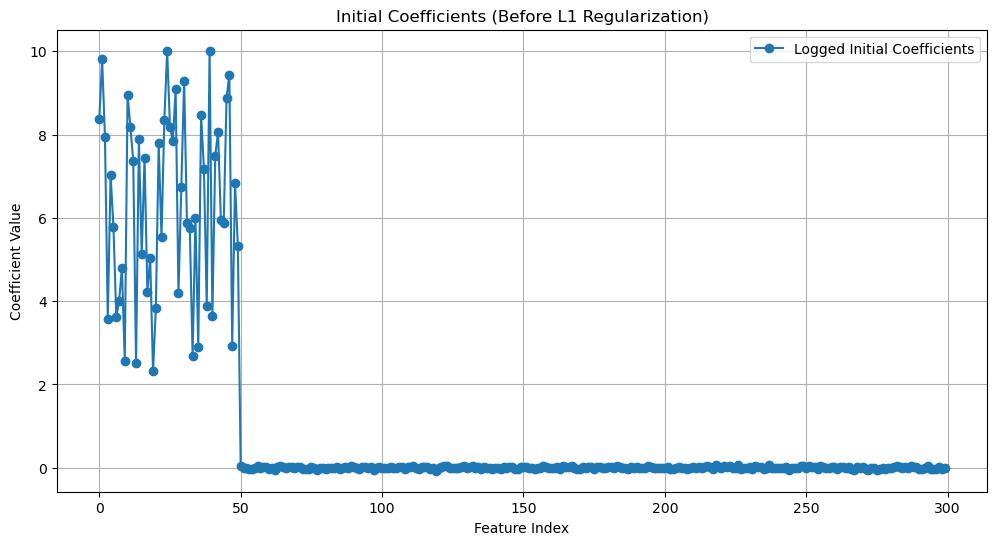

In [17]:
# Plot initial coefficients
plt.figure(figsize=(12, 6))
plt.plot(coefficients_df['Feature_Index'], coefficients_df['Initial_Coefficients'], marker='o', label='Logged Initial Coefficients', linestyle='-')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Initial Coefficients (Before L1 Regularization)')
plt.legend()
plt.grid(True)
plt.show()


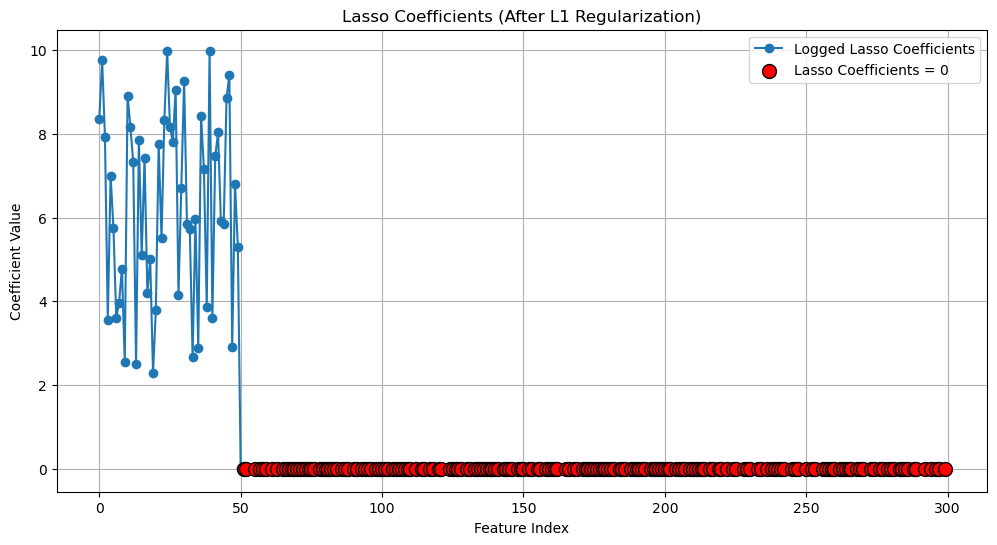

In [18]:
# Plot Lasso coefficients
plt.figure(figsize=(12, 6))
plt.plot(coefficients_df['Feature_Index'], coefficients_df['Lasso_Coefficients'], marker='o', label='Logged Lasso Coefficients', linestyle='-')
plt.scatter(zero_indices, np.zeros(len(zero_indices)), color='red', edgecolor='black', s=100, zorder=5, label='Lasso Coefficients = 0')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Lasso Coefficients (After L1 Regularization)')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
coefficients_df = coefficients_df.sort_values(by="Lasso_Coefficients", ascending=False).reset_index(drop=True)
coefficients_df

,Feature_Index,Feature,Initial_Coefficients,Lasso_Coefficients
0,24,x25,10.013204,9.991332
1,39,x40,10.015202,9.989843
2,1,x2,9.807235,9.781358
3,46,x47,9.439084,9.413674
4,30,x31,9.299463,9.273814
...,...,...,...,...
295,77,x78,-0.046824,-0.023192
296,244,x245,-0.051885,-0.026383
297,267,x268,-0.054228,-0.027087
298,272,x273,-0.056613,-0.034080


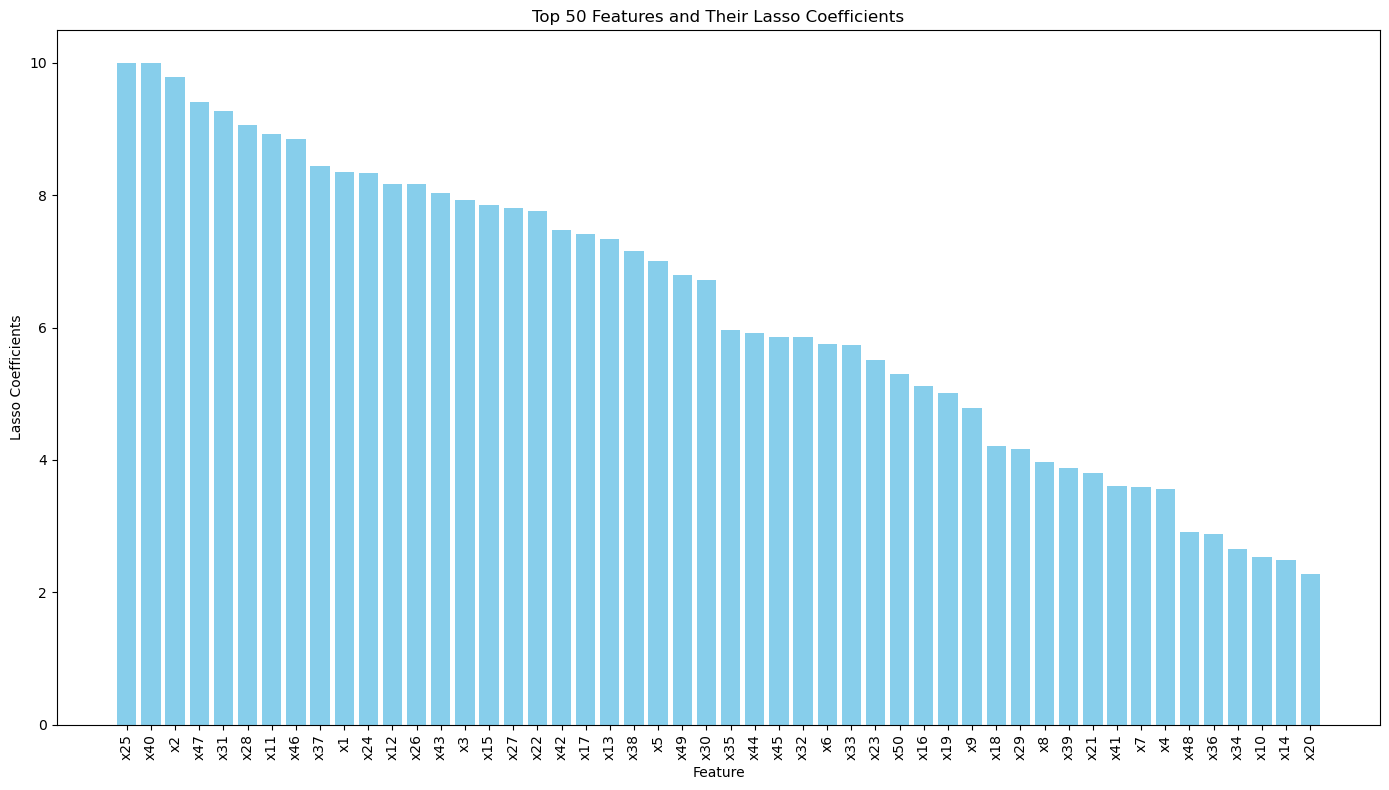

In [20]:
top_50_features = coefficients_df[['Feature', 'Lasso_Coefficients']]
top_50_filtered_df = top_50_features.head(50)

plt.figure(figsize=(14, 8))

plt.bar(top_50_filtered_df['Feature'], top_50_filtered_df['Lasso_Coefficients'], color='skyblue')

plt.xlabel('Feature')
plt.ylabel('Lasso Coefficients')
plt.title('Top 50 Features and Their Lasso Coefficients')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

end_time = time.time()

In [21]:
explainability_time = end_time - start_time

In [22]:
# Create a DataFrame for the results
results = pd.DataFrame({'True Values': y_test, 'Predicted Values': y_pred}).reset_index(drop=True)
results

,True Values,Predicted Values
0,141.024717,140.759530
1,172.778688,173.609122
2,159.184445,157.917486
3,173.486573,174.004636
4,145.868785,146.296693
...,...,...
5995,154.254760,154.470023
5996,176.318187,178.744718
5997,153.272855,154.458245
5998,158.212418,157.699623


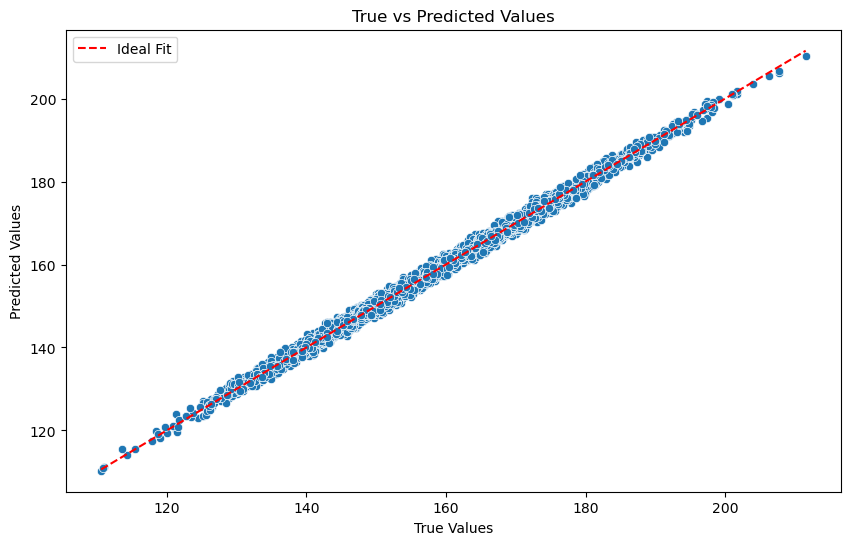

In [23]:
# Plot the true vs. predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x='True Values', y='Predicted Values', data=results)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

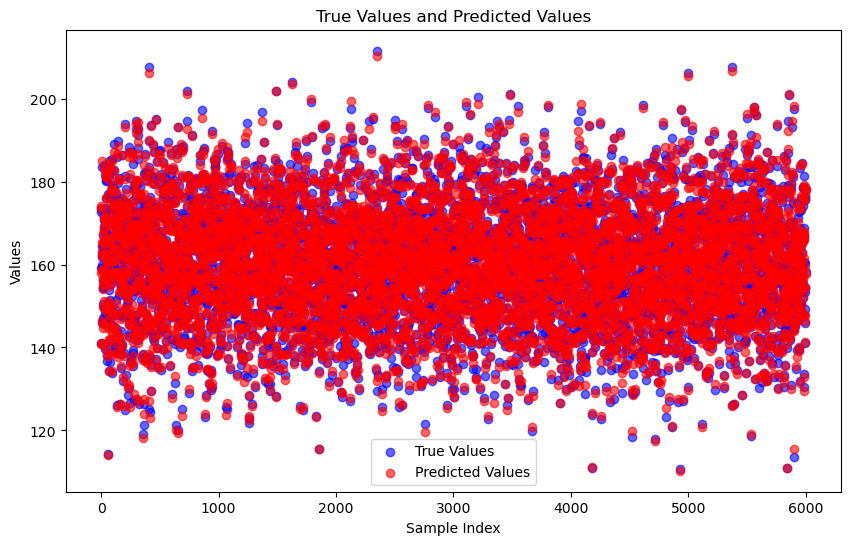

In [24]:
# Plot the true vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', alpha=0.6, label='True Values')
plt.scatter(range(len(y_pred)), y_pred, color='red', alpha=0.6, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('True Values and Predicted Values')
plt.legend()
plt.show()

In [25]:
# # Exclude non-numeric columns
# corrmat = data.corr()

# f, ax = plt.subplots(figsize=(15, 12))
# sns.heatmap(corrmat, annot=True);

In [26]:
# # Threshold for identifying multicollinearity
# threshold = 0.5

# # Find pairs of highly correlated features
# high_corr_var = {}
# for i in range(len(corrmat.columns)):
#     for j in range(i):
#         if abs(corrmat.iloc[i, j]) > threshold:
#             colname = corrmat.columns[i]
#             if colname not in high_corr_var:
#                 high_corr_var[colname] = corrmat.columns[j]

# print("Highly correlated features (above threshold of {}):".format(threshold))
# for key, value in high_corr_var.items():
#     print(key, "<--->", value)

## shows no multicollinearity in random generated data

# Time to collect result metrics

In [27]:
lasso_metrics = []
# LassoCV model metrics
#fpr, fnr = calculate_fp_fn_rates(cf_matrix)
lasso_metrics.append({
    'Simulation Size': '50-250-30_000',
    'Model': 'Lasso',
    'Inference Time (sec)': round(estimation_time, 3),
    'R Squared': r2,
    'RMSE': rmse,
    'Explanation/Interpretation Task': 'Interpret LASSO',
    'Interpretation Time (sec)': round(explainability_time, 3),
    #'top_50_features': top_50_features_str
    # 'auc': round(roc_auc, 3),
    # 'false_positive_rate': round(fpr, 3),
    # 'false_negative_rate': round(fnr, 3)
})

lasso_metrics_df = pd.DataFrame(lasso_metrics)
lasso_metrics_df

,Simulation Size,Model,Inference Time (sec),R Squared,RMSE,Explanation/Interpretation Task,Interpretation Time (sec)
0,50-250-30_000,Lasso,1.021,0.994631,0.99945,Interpret LASSO,0.909


In [28]:
lasso_metrics_df.to_csv('50-250-30_000-metrics.csv', index=False)